# Homework 2, *part 2* (60 points)

In this assignment you will build a heavy convolutional neural net (CNN) to solve Tiny ImageNet image classification. Try to achieve as high accuracy as possible.

## Deliverables

* This file,
* a "checkpoint file" from `torch.save(model.state_dict(), ...)` that contains model's weights (which a TA should be able to load to verify your accuracy).

## Grading

* 9 points for reproducible training code and a filled report below.
* 12 points for building a network that gets above 20% accuracy.
* 6.5 points for beating each of these milestones on the validation set:
  * 25.0%
  * 30.0%
  * 32.5%
  * 35.0%
  * 37.5%
  * 40.0%
    
## Restrictions

* Don't use pretrained networks.

## Tips

* One change at a time: never test several new things at once.
* Google a lot.
* Use GPU.
* Use regularization: L2, batch normalization, dropout, data augmentation.
* Use Tensorboard ([non-Colab](https://github.com/lanpa/tensorboardX) or [Colab](https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6)) or a similar interactive tool for viewing progress.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving tiny_imagenet.py to tiny_imagenet.py


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import tiny_imagenet
tiny_imagenet.download(".")

Dataset not exists or is broken, downloading it


In [6]:
!ls -al

total 242316
drwxr-xr-x 1 root root      4096 Apr 17 11:20 .
drwxr-xr-x 1 root root      4096 Apr 17 11:19 ..
drwxr-xr-x 1 root root      4096 Apr  4 20:19 .config
drwxr-xr-x 2 root root      4096 Apr 17 11:20 __pycache__
drwxr-xr-x 1 root root      4096 Apr  4 20:20 sample_data
drwxr-xr-x 5 root root      4096 Apr 17 11:21 tiny-imagenet-200
-rw-r--r-- 1 root root 248100043 Apr 17 11:20 tiny-imagenet-200.zip
-rw-r--r-- 1 root root      1242 Apr 17 11:20 tiny_imagenet.py


Training and validation images are now in `tiny-imagenet-200/train` and `tiny-imagenet-200/val`.

In [0]:
train_folder = 'tiny-imagenet-200/train'
val_folder = 'tiny-imagenet-200/val'

In [0]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import torch.optim as optim
import os

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
data_transform = transforms.Compose([
        transforms.RandomChoice(
        [
            transforms.RandomHorizontalFlip(),
            transforms.Compose([]),
            transforms.Compose([
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
            ]),
            transforms.Compose([
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomHorizontalFlip()
            ]),
            transforms.Compose([
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
            ]),
            transforms.Compose([
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
            ]),
            transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
            ]),
        ]
    ),
    transforms.CenterCrop((64,64)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_folder, transform=data_transform)
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)

val_dataset = datasets.ImageFolder(val_folder, transform=transforms.Compose([
    transforms.CenterCrop((64,64)),
    transforms.ToTensor()
]))
val_loader = data.DataLoader(val_dataset, batch_size=256)

In [0]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=200):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=5, stride=1, padding=2),
            nn.PReLU(),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 86, kernel_size=5, padding=2),
            nn.PReLU(),
            nn.BatchNorm2d(num_features=86),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(86, 86, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.BatchNorm2d(num_features=86),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(86, 192, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
    
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 3 * 3, 2048),
            nn.PReLU(),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.PReLU(),
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 3 * 3)
        x = self.classifier(x)
        return x

In [0]:
model = AlexNet().to(device)

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

In [118]:
!pip install livelossplot

In [0]:
from livelossplot import PlotLosses

dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

In [0]:
def train_model(model, criterion, optimizer, num_epochs=10, path_to_save_models='models/L2reg_addlayer_BatchNorm_Prelu_Augmented_bs256sgd0.01/'):
    try:
        os.makedirs(path_to_save_models)
    except Exception:
        pass
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'cross entropy loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.draw()
        
        if epoch % 10 == 9:
            torch.save(model.state_dict(), os.path.join(path_to_save_models, 'epoch_{}.mdl'.format(epoch)))
        
        #if epoch == 19:
        #    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        
            

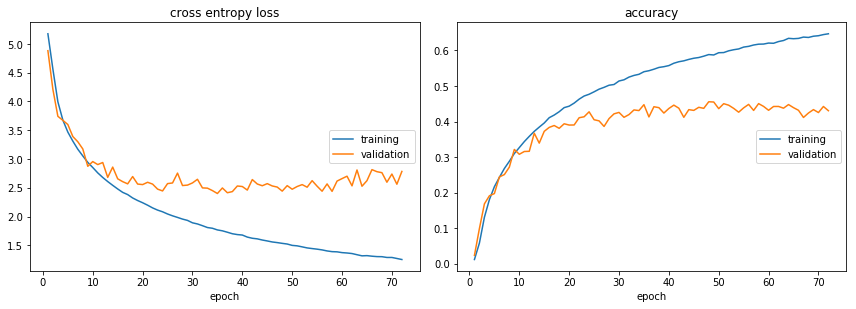

cross entropy loss:
training   (min:    1.254, max:    5.174, cur:    1.254)
validation (min:    2.400, max:    4.881, cur:    2.783)

accuracy:
training   (min:    0.011, max:    0.647, cur:    0.647)
validation (min:    0.023, max:    0.456, cur:    0.430)


KeyboardInterrupt: ignored

In [121]:
train_model(model, criterion, optimizer, num_epochs=100)

In [0]:
dfrom google.colab import files
files.download('models/bs32sgd0.0005/epoch_119.mdl') 

In [0]:
from google.colab import files
files.download('models/bs128sgd0.01/epoch_39.mdl') 

In [0]:
from google.colab import files
files.download('models/L2reg_addlayer_BatchNorm_Prelu_Augmented_bs256sgd0.01/epoch_39.mdl') 

When everything is done, please compute accuracy on the validation set and report it below.

In [123]:
# model loading
model = AlexNet().to(device)
#model.load_state_dict(torch.load('models/L2reg_addlayer_BatchNorm_Prelu_Augmented_bs256sgd0.01/epoch_39.mdl')) # colab
model.load_state_dict(torch.load('L2reg_addlayer_BatchNorm_Prelu_Augmented_bs256sgd0.01_epoch_39.mdl')) # local
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 86, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): PReLU(num_parameters=1)
    (6): BatchNorm2d(86, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(86, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): PReLU(num_parameters=1)
    (10): BatchNorm2d(86, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(86, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): PReLU(num_parameters=1)
    (14

In [124]:
for phase in ['train', 'validation']:
  if phase == 'train':
      model.train()
  else:
      model.eval()

  running_corrects = 0

  for inputs, labels in dataloaders[phase]:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      _, preds = torch.max(outputs, 1)
      running_corrects += torch.sum(preds == labels.data)

  epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
  
  print("{phase} accuracy: {accuracy}".format(phase=phase, accuracy=epoch_acc))

train accuracy: 0.5962799787521362
validation accuracy: 0.45419999957084656


# Report

Below, please mention

* a brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method (batch size, optimization algorithm, ...) and why?
* Any regularization and other techniques applied and their effects;

The reference format is:

*"I have analyzed these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such".*

* I started with Alexnet original model (https://www.nvidia.cn/content/tesla/pdf/machine-learning/imagenet-classification-with-deep-convolutional-nn.pdf) with reduced by 0.5 number of filters (or neurons if we talk about classifier) in each layer and reduced receptive field and stride in the first convolution (hence images are 4 times smaller)
* Performed some test runs (without augmentation) to find out so-so optimal batch size, optimizer parameters and the number of epochs.
* Started with 1000 epochs (to stop early), 128bs, 0.01 lr and 0.9 momentum for sgd optimizer. Each epoch calculates quite long time, so it's a good idea to check bs 64. I suppose it will not affect learning curve dramatically, but will save my time. I observed the process for 10 epochs and it seems like 0.01 is to much. I can't see any (desired) changes in the loss curve. See https://s.mail.ru/Mpa6/rPRTqa1i3
* So let's reduce bs to 64 and lr to 0.001. Seems like it's also not so good choice https://s.mail.ru/4xiN/pgoBBH9ao
* Let's turn to 32 bs and lr 0.0005. It seems like it's again stuck in the local minimum. https://s.mail.ru/LpVG/ZzZvB68bj
* oooh it seems like i found out the REAL problem. I forgot to shuffle the data :). Let's see what we'll get with shuffling. Seems like everything goes nice https://s.mail.ru/DHKD/yjZESCCyt Continue to wait... level 20 reached https://s.mail.ru/7LMB/sFgMs74Sq Look at this step in the beginning. I think that the reason is a small batch size. We have 200 classes, 32 samples don't cover such diversity. Let's increase the bs to be 128 in the next try. I would say that on epoch 120 it starts to overfit https://s.mail.ru/8u1s/hRZv7zSBR
* So let's try bs 128 and lr 0.0005. https://s.mail.ru/4j42/2WYG53WWa let's try to change learning rate. It seems to me that changes on each step are not sufficient.
* bs 128 lr 0.01. https://s.mail.ru/BqGX/9QnpgiStW the process goes way more faster! New horizons in front! I just need to deal with overfitting...
* So, basically I'll use lr 0.01, momentum 0.9 and bs 128. Let's make something different
* Let's add some augmentation to force model to be more robust and less overfit. And it helped a bit. 35+ reached https://s.mail.ru/KWeH/VJMykTA46
* Changed activations to prelu. Got 39 on validation...
* Let's try batch normalization instead of vanilla LocalResponseNorm. Dramatically increased learning speed. Reached 0.4 on some step but just for one moment, overfitting is still the issue. https://s.mail.ru/JncC/7XCW9xMEK
* Let's try to reduce learning rate at the step 20 to 0.001 for better stability and see what's happen. https://s.mail.ru/8Y8B/NEm5kCUEU so I reached 43, but still overfitting problem is not solved... 
* For me it feels like I need to use bigger batch size. If it will not help I'll try to somehow change the model structure (and also add ColorGitter to augmentation).
* With bs 256 learning curve is more stable https://s.mail.ru/6uTi/j3zVW5VgM but overfitting is still there
* Let's try to add one more layer with batch norm in the middle of the network. https://s.mail.ru/KQfG/5xFGmfana it didn't work out. I think the problem is the reduced amount of features before dense layers (it's just 128 now and recenetly it was 128*3*3)
* Let's make the kernel size for the first convolution to be 5 instead of 7. Then in the end there'll be more features. Also I'll try to increase the number of filters in the first convolution (from 64 to 128). I think this variaty of filters can help reduce overfitting. https://s.mail.ru/FA9M/jUirFrg9Q So this worked a bit, but still not ideal.
* Let's add the regulatization term with lambda=0.0005. At least we surely crossed 0.4 line. So let's finish on this. https://s.mail.ru/5UXL/ssYAHJtJg